In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)

## Introduction 

In [2]:
smartphones = pd.read_csv('../Data sets/smartphone_raw.csv')

In [3]:
smartphones.shape

(338018, 5)

In [4]:
smartphones.head()

,event_time,event_type,category_id,price,user_id
0,2019-10-01 00:02:14 UTC,purchase,2053013555631882655,130.76,543272936
1,2019-10-01 00:04:37 UTC,purchase,2053013555631882655,642.69,551377651
2,2019-10-01 00:10:08 UTC,purchase,2053013555631882655,515.67,524325294
3,2019-10-01 00:14:14 UTC,purchase,2053013555631882655,463.31,555083442
4,2019-10-01 02:19:10 UTC,purchase,2053013555631882655,736.18,515246296


In [5]:
smartphones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338018 entries, 0 to 338017
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   event_time   338018 non-null  object 
 1   event_type   338018 non-null  object 
 2   category_id  338018 non-null  int64  
 3   price        338018 non-null  float64
 4   user_id      338018 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 12.9+ MB


## Data cleaning

In [6]:
round((smartphones.isnull().sum() / smartphones.shape[0]) * 100, 2)

event_time     0.0
event_type     0.0
category_id    0.0
price          0.0
user_id        0.0
dtype: float64

Данные чистые. Заполнять искусственно не нужно.

## Data Preparation

Удалим время у фичи `event_time`, и переименуем ее в `event_date`

In [7]:
smartphones['event_time'] = pd.to_datetime(smartphones['event_time'])

In [8]:
smartphones['event_time'] = smartphones['event_time'].map(lambda x: 10000*x.year + 100*x.month + x.day)

In [9]:
smartphones = smartphones.rename(columns={'event_time': 'event_date'})

In [10]:
smartphones.head()

,event_date,event_type,category_id,price,user_id
0,20191001,purchase,2053013555631882655,130.76,543272936
1,20191001,purchase,2053013555631882655,642.69,551377651
2,20191001,purchase,2053013555631882655,515.67,524325294
3,20191001,purchase,2053013555631882655,463.31,555083442
4,20191001,purchase,2053013555631882655,736.18,515246296


Удалю колонки, которые нам уже ненужные колонки - `category_id` и `event_type`

In [11]:
smartphones = smartphones.drop(['category_id', 'event_type'], axis=1)

In [12]:
smartphones.head()

,event_date,price,user_id
0,20191001,130.76,543272936
1,20191001,642.69,551377651
2,20191001,515.67,524325294
3,20191001,463.31,555083442
4,20191001,736.18,515246296


In [13]:
smartphones.to_csv('../Data sets/smartphones_cleaned.csv', index=False)

И снова сократил с 23,7 MB до 12 MB. И притом оставили только нужные нам данные.

### RFM

Для кластеризации пользователей я буду использовать сегментацию **RFM**.

**RFM** (**R**ecency **F**requency **M**onetary) - разделение клиентов на сегменты от степени их лояльности.

У такой сегментации всего 3 колонки:

**R**ecency (давность) - давность прошлой сделки, сколько времени прошло с прошлой покупки. Предполагается, чем меньше эта метрика, тем больше вероятность будущей, повторной покупки.

**F**requency (частота) - кол-во покупок. Больше покупок, больше вероятность возвращение клиента.

**M**onetary (денежная масса, деньги) - сумма сделок. Чем больше потратил клиент, тем больше вероятность возвращение клиента.

### Data Transformation 

In [14]:
# Для начала найдем уникальных юзеров 

users = pd.DataFrame({'user_id': smartphones['user_id'].unique()})

In [15]:
users.head()

,user_id
0,543272936
1,551377651
2,524325294
3,555083442
4,515246296


In [16]:
# Их кстати 
users.shape[0]

160437

### Соберем дату последней покупке юзеров

In [17]:
last_ordered_date = smartphones.groupby(['user_id'])['event_date'].agg('max')

In [18]:
zipped_last_ordered_date = zip(last_ordered_date.index, last_ordered_date.values)

In [19]:
%%time
for index, value in zipped_last_ordered_date:
    users.loc[users['user_id'] == index, 'order_time_offset'] = value - 20191031

CPU times: user 2min 16s, sys: 479 ms, total: 2min 17s
Wall time: 2min 17s


In [21]:
users.head()

,user_id,order_time_offset
0,543272936,0.0
1,551377651,-6.0
2,524325294,-23.0
3,555083442,-26.0
4,515246296,-7.0


### Теперь соберем информацию о кол-во покупок.

In [22]:
n_orders = smartphones.groupby(['user_id']).agg('count')['price']

In [23]:
zipped_n_orders = zip(n_orders.index, n_orders.values)

In [24]:
%%time
for index, value in zipped_n_orders:
    users.loc[users['user_id'] == index, 'n_orders'] = value

CPU times: user 2min 20s, sys: 680 ms, total: 2min 20s
Wall time: 2min 21s


In [25]:
users.head()

,user_id,order_time_offset,n_orders
0,543272936,0.0,32.0
1,551377651,-6.0,13.0
2,524325294,-23.0,3.0
3,555083442,-26.0,2.0
4,515246296,-7.0,8.0


### Просуммируем цены заказов.

In [26]:
amount = smartphones.groupby(['user_id'])['price'].agg('sum')

In [27]:
zipped_amount = zip(amount.index, amount.values)

In [28]:
%%time
for index, value in zipped_amount:
    users.loc[users['user_id'] == index, 'amount'] = value

CPU times: user 2min 23s, sys: 657 ms, total: 2min 23s
Wall time: 2min 24s


In [29]:
users.head()

,user_id,order_time_offset,n_orders,amount
0,543272936,0.0,32.0,4388.45
1,551377651,-6.0,13.0,4311.08
2,524325294,-23.0,3.0,1752.46
3,555083442,-26.0,2.0,754.24
4,515246296,-7.0,8.0,3754.73


In [30]:
users.head()

,user_id,order_time_offset,n_orders,amount
0,543272936,0.0,32.0,4388.45
1,551377651,-6.0,13.0,4311.08
2,524325294,-23.0,3.0,1752.46
3,555083442,-26.0,2.0,754.24
4,515246296,-7.0,8.0,3754.73


In [31]:
rfm = users.drop('user_id', axis=1)

In [32]:
rfm.head()

,order_time_offset,n_orders,amount
0,0.0,32.0,4388.45
1,-6.0,13.0,4311.08
2,-23.0,3.0,1752.46
3,-26.0,2.0,754.24
4,-7.0,8.0,3754.73


In [33]:
rfm['order_time_offset'] = rfm['order_time_offset'].astype(int)
rfm['n_orders'] = rfm['n_orders'].astype(int)
rfm['amount'] = rfm['amount'].astype(int)

In [34]:
rfm.head()

,order_time_offset,n_orders,amount
0,0,32,4388
1,-6,13,4311
2,-23,3,1752
3,-26,2,754
4,-7,8,3754


### Переименование и упорядочевания колонок.
Для красоты и понятности переименую колонки и упорядочую как в аббревиатуре. 

In [35]:
rfm = rfm.rename( \
    columns={'n_orders': 'Recency', 'order_time_offset':'Frequency', 'amount': 'Monetary'}
)

In [36]:
rfm.head()

,Frequency,Recency,Monetary
0,0,32,4388
1,-6,13,4311
2,-23,3,1752
3,-26,2,754
4,-7,8,3754


In [37]:
rfm = rfm[['Recency', 'Frequency', 'Monetary']]

In [38]:
rfm.head()

,Recency,Frequency,Monetary
0,32,0,4388
1,13,-6,4311
2,3,-23,1752
3,2,-26,754
4,8,-7,3754


## Визуализация 

Визуализация распределение по гистограмме, QQPlot и Boxplot.

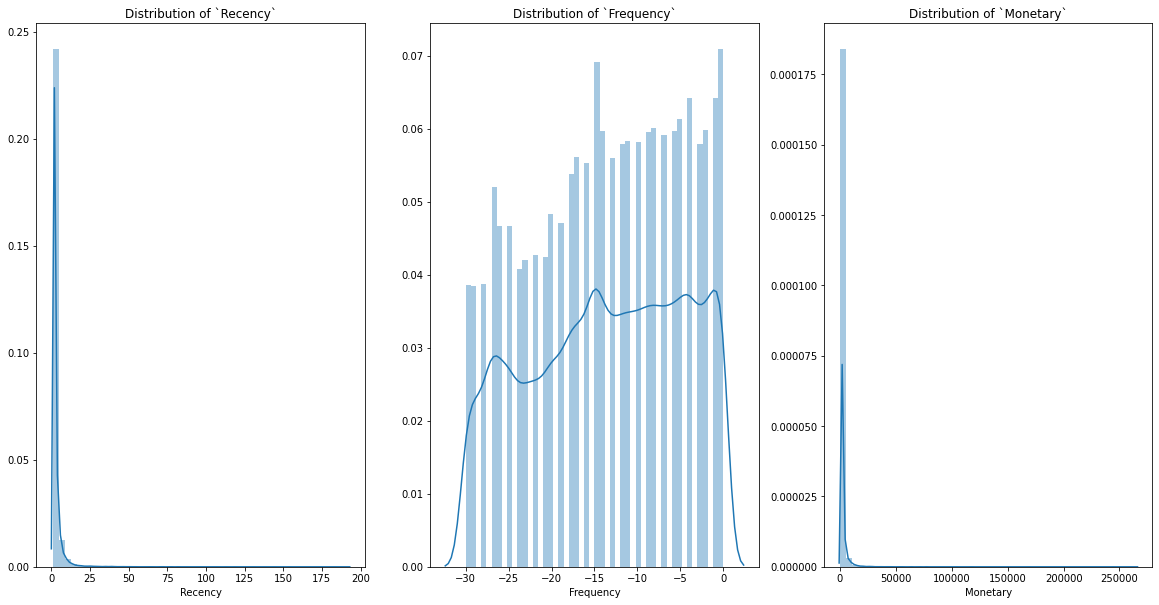

In [39]:
fig, axes = plt.subplots(1, 3)
rec_hist = sns.distplot(ax=axes[0], a=rfm['Recency'], kde=True)
rec_hist.set_title('Distribution of `Recency`')

fre_hist = sns.distplot(ax=axes[1], a=rfm['Frequency'], kde=True)
fre_hist.set_title('Distribution of `Frequency`')

mon_hist = sns.distplot(ax=axes[2], a=rfm['Monetary'], kde=True)
mon_hist.set_title('Distribution of `Monetary`');

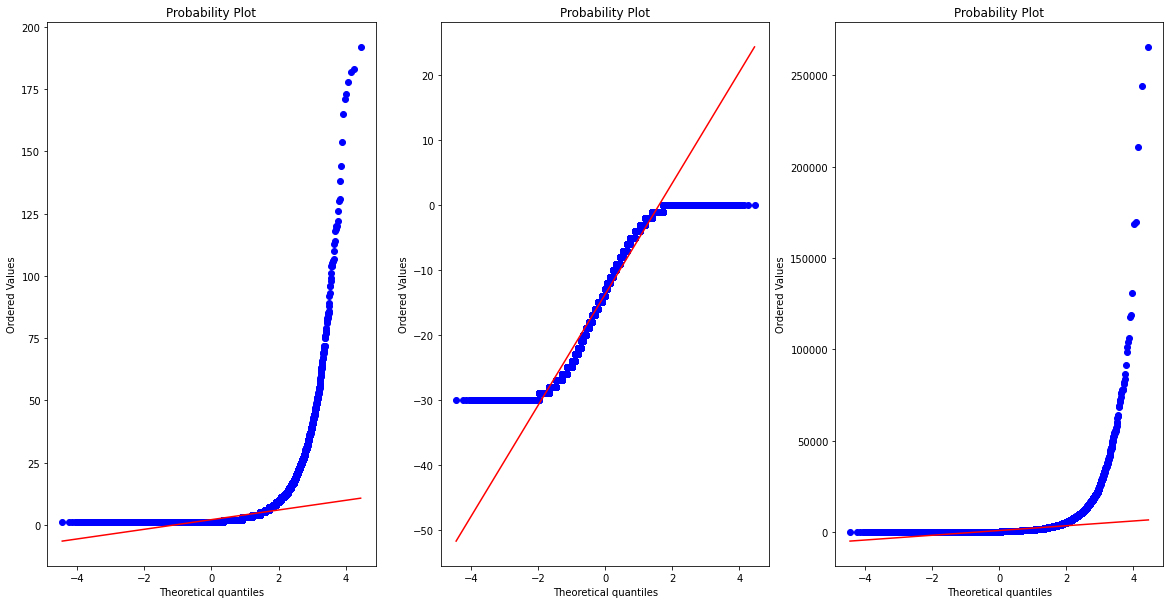

In [40]:
from scipy import stats

fig, axes = plt.subplots(1, 3)
stats.probplot(x=rfm['Recency'], dist="norm", plot=axes[0])
stats.probplot(x=rfm['Frequency'], dist="norm", plot=axes[1])
stats.probplot(x=rfm['Monetary'], dist="norm", plot=axes[2]);

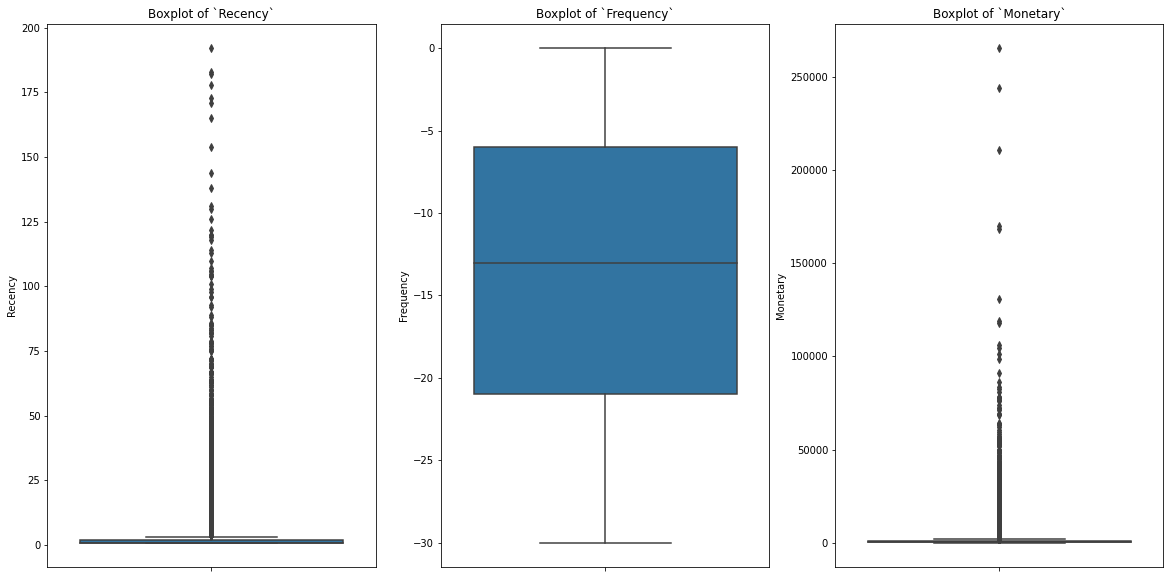

In [41]:
fig, axes = plt.subplots(1, 3)
rec_box = sns.boxplot(ax=axes[0], y=rfm['Recency'])
rec_box.set_title('Boxplot of `Recency`')

fre_box = sns.boxplot(ax=axes[1], y=rfm['Frequency'])
fre_box.set_title('Boxplot of `Frequency`')

mon_box = sns.boxplot(ax=axes[2], y=rfm['Monetary'])
mon_box.set_title('Boxplot of `Monetary`');

### Скалирование величин.
У многих алгоритмы кластеризации под капотом вычисляют дистанции (Euclidean, Manhattan). Поэтому скалирование величин **обязательный** гость программы.

Я буду использовать `StandardScaler`, поскольку потом я собираюсь удалить выбросы. 

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for column in rfm.columns:
    rfm[column] = scaler.fit_transform(rfm[[column]])

In [43]:
rfm.head()

,Recency,Frequency,Monetary
0,8.072395,1.563118,1.292309
1,2.941603,0.878317,1.263125
2,0.241186,-1.061953,0.293215
3,-0.028856,-1.404354,-0.085046
4,1.591394,0.764183,1.052011


In [44]:
del scaler
del smartphones

In [45]:
rfm_scaled = rfm.copy()

### Удаление выбросов.

`StandardScaler` это тоже самое, что и z-score. По правилу трех сигм, наблюдения, которые лежат дальше +-3$\sigma$ - выбросы.

In [46]:
for column in rfm.columns:
    rfm_scaled = rfm_scaled[(rfm_scaled[column] < 3) & (rfm_scaled[column] > -3)]

In [47]:
rfm_scaled.head()

,Recency,Frequency,Monetary
1,2.941603,0.878317,1.263125
2,0.241186,-1.061953,0.293215
3,-0.028856,-1.404354,-0.085046
4,1.591394,0.764183,1.052011
6,-0.298898,-1.860888,-0.012274


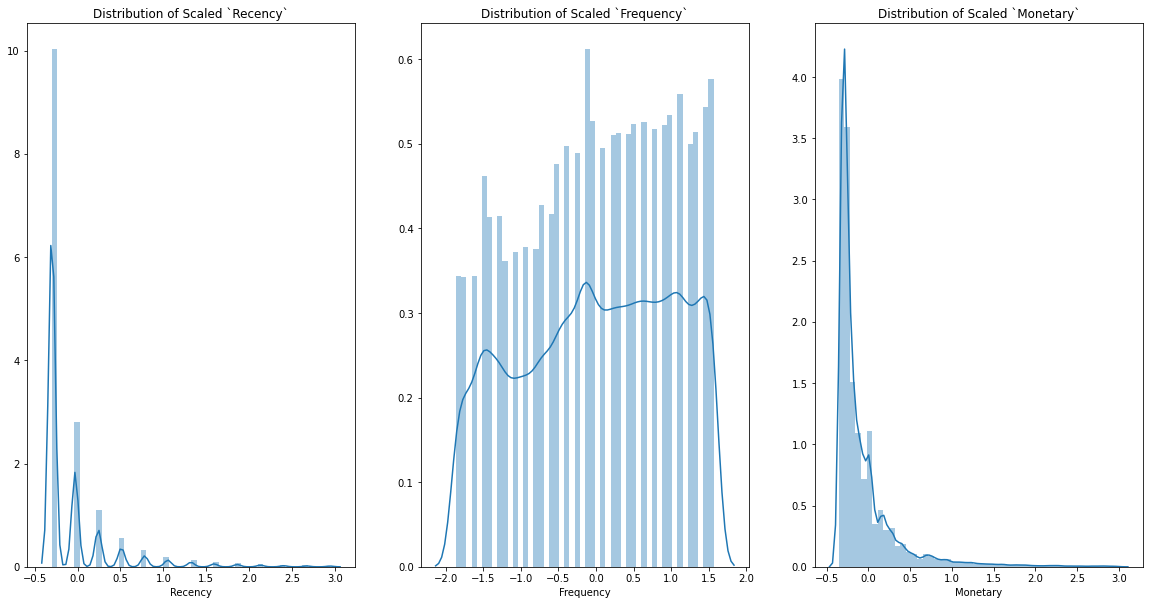

In [48]:
fig, axes = plt.subplots(1, 3)
rec_hist = sns.distplot(ax=axes[0], a=rfm_scaled['Recency'], kde=True)
rec_hist.set_title('Distribution of Scaled `Recency`')

fre_hist = sns.distplot(ax=axes[1], a=rfm_scaled['Frequency'], kde=True)
fre_hist.set_title('Distribution of Scaled `Frequency`')

mon_hist = sns.distplot(ax=axes[2], a=rfm_scaled['Monetary'], kde=True)
mon_hist.set_title('Distribution of Scaled `Monetary`');

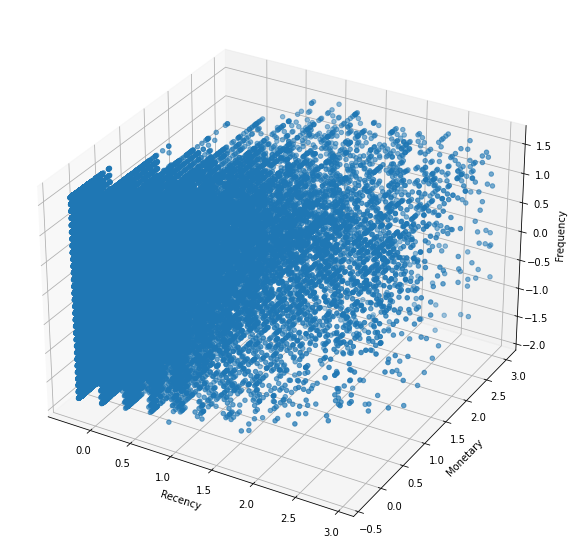

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(rfm_scaled['Recency'], rfm_scaled['Monetary'], rfm_scaled['Frequency'])
ax.set_xlabel("Recency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Frequency")
plt.show()

После удаление выбросов стало распеределение стало чуть лучше.

### Тренировка модели

В качестве модели, я буду использовать простой и быстрый алгоритм Kmeans.

Для нахождения количества кластеров, я воспользую методом `Elbow`.

In [50]:
from sklearn.cluster import KMeans

In [51]:
results = []
range_clust = range(2, 15)

for num in range_clust:
    kmeans = KMeans(n_clusters=num)
    kmeans.fit(rfm_scaled)
    
    results.append({'N_clusters': num, 'Inertia': kmeans.inertia_})
results = pd.DataFrame(results)

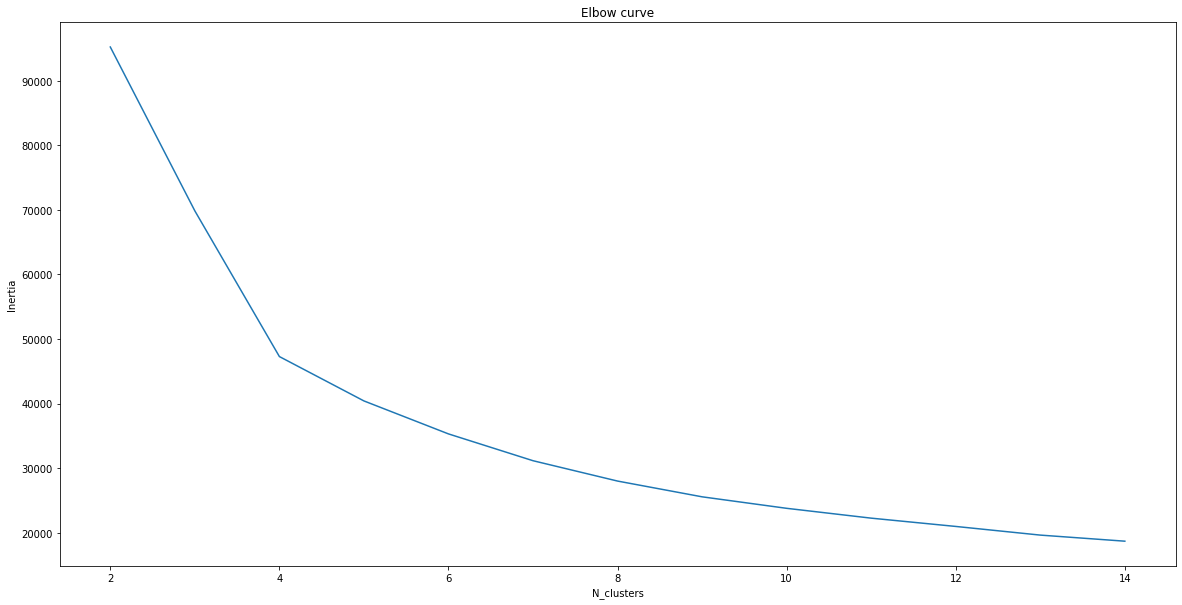

In [52]:
elbow_curve = sns.lineplot(data=results, x='N_clusters', y='Inertia');
elbow_curve.set_title("Elbow curve");

***По методу Elbow выбираем ответ 4.*** <img src='https://miro.medium.com/max/1400/1*eVyOdx4gIcGWQ3lF4xAu6g.png' width='400' heigh='200'/>

In [53]:
kmeans_elbow = KMeans(n_clusters=4)
kmeans_elbow.fit(rfm_scaled)

KMeans(n_clusters=4)

In [54]:
rfm_scaled['Cluster_id'] = kmeans_elbow.labels_

In [55]:
rfm_scaled['Cluster_id'] = rfm_scaled['Cluster_id'] + 1

In [56]:
rfm_scaled.head()

,Recency,Frequency,Monetary,Cluster_id
1,2.941603,0.878317,1.263125,4
2,0.241186,-1.061953,0.293215,1
3,-0.028856,-1.404354,-0.085046,1
4,1.591394,0.764183,1.052011,4
6,-0.298898,-1.860888,-0.012274,1


## Визуализация кластеризации

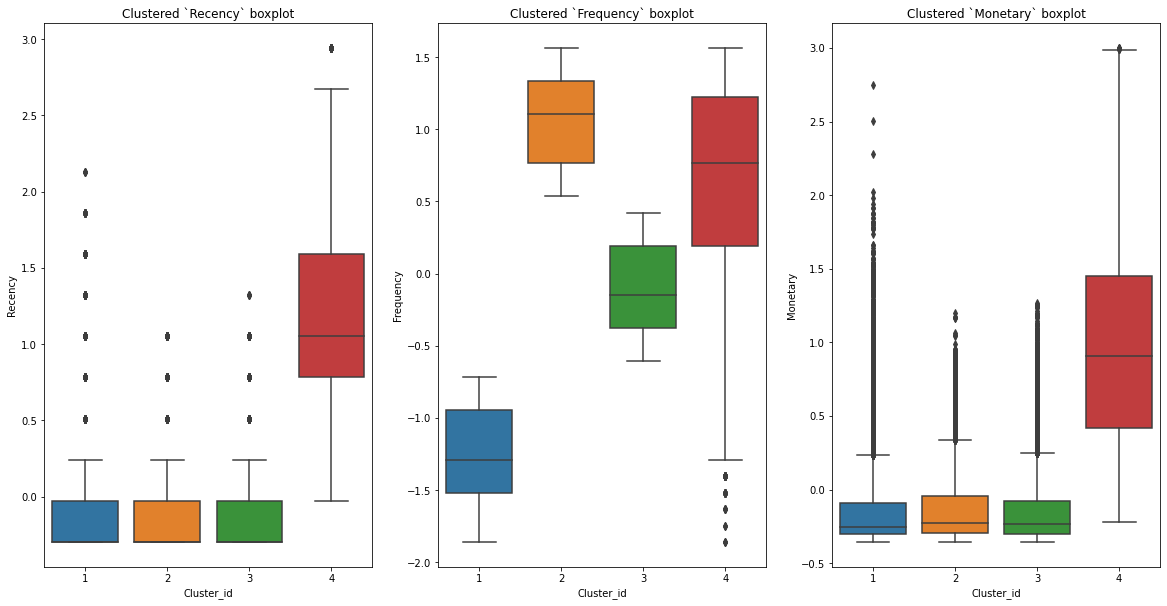

In [57]:
fig, axes = plt.subplots(1,3)

rec_cluster = sns.boxplot(ax=axes[0], x='Cluster_id', y='Recency', data=rfm_scaled);
rec_cluster.set_title("Clustered `Recency` boxplot")
freq_cluster = sns.boxplot(ax=axes[1], x='Cluster_id', y='Frequency', data=rfm_scaled);
freq_cluster.set_title("Clustered `Frequency` boxplot")
mon_cluster = sns.boxplot(ax=axes[2], x='Cluster_id', y='Monetary', data=rfm_scaled);
mon_cluster.set_title("Clustered `Monetary` boxplot");

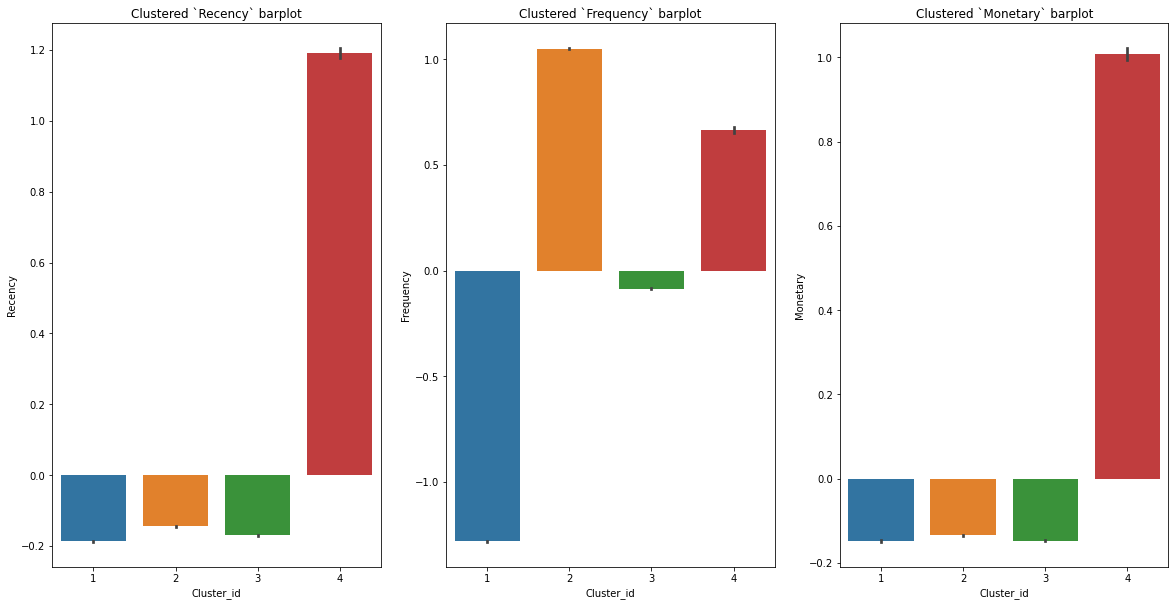

In [58]:
fig, axes = plt.subplots(1,3)

rec_cluster = sns.barplot(ax=axes[0], x='Cluster_id', y='Recency', data=rfm_scaled);
rec_cluster.set_title("Clustered `Recency` barplot")
freq_cluster = sns.barplot(ax=axes[1], x='Cluster_id', y='Frequency', data=rfm_scaled);
freq_cluster.set_title("Clustered `Frequency` barplot")
mon_cluster = sns.barplot(ax=axes[2], x='Cluster_id', y='Monetary', data=rfm_scaled);
mon_cluster.set_title("Clustered `Monetary` barplot");

## Описание кластеров

**Первый кластер.** Большинство пользователей в первом кластере покупают мало, часто и недавно покупали продукт. 

**Второй кластер** похож на первый кластер, но есть особенное различие в частоте покупок, но ниже среднего.

**Третий кластер** самый прибыль для нас, он генерирует больше всего выручки и пользователи в нем довольно часто покупают продукты, но не все их кластера недавно делали покупки. Нам выгодно их вернуть.

**Четвертый кластер** похож на первый и на второй, у него я бы попытался улучшить средний чек с помощью групповых продаж. Поскольку пользователи в этом кластере покупали недавно и частота покупок чуть выше средней.

## Гипотезы - как добыть выгоду из каждого кластера.

**Первый кластер.** Мое мнение, раздавать всему кластеру промокод на скидку - неправильно. Многие из этого кластера и так придут к нам за покупкой. Промокод на скидку я бы выдал, только 5% клиентов с наивысшим показателем `Monetary`. Это поможет вернуть "толстых кошельков" из этого кластера.

А на остальных можно было бы проверить гипотезу АБ тестом - что при активном оповещении о скидках, будь то push-уведомления или email-маркетинг, средний чек увеличится.

**Второй кластер.**  На них тоже можно развернуть тот же АБ тест с активном оповещении о скидках, но попытаться улучшить среднее кол-во заказов за 30 дней.

**Третий кластер.** Вернуть покупателей можно с помощью промокода на 10-30% скидку или подарка премуим аккаунта с условиями сниженной цены.

Также возможно, что этот кластер - оптовики, розничные продавцы покупающие большие партии, и чтобы улучшить отношения с ними, нужно рассмотреть отдельный ценовую политику для них, чтобы это было выгодно, как и для нас, так и для них.

**Четвертый кластер.** В нем я бы попытался увеличит средний чек с помощью групповых продаж. Например, телевизор стоит 40 тысяч рублей, приставка к нему 25 тысяч, общая сумма 65 тысяч. Но по специальному предложению они вместе будут стоит 58 тысяч.

**Примечание:** Такие продажи для нас тоже должны быть выгодны.